# Detección de Ataques en Tráfico de Red con IDS

Este notebook documenta el proyecto completo de entrenamiento, predicción y evaluación de un modelo de detección de intrusiones (IDS) utilizando el dataset CICIDS2017 y tráfico de red simulado.

Se incluyen las siguientes etapas:
1. Carga y preprocesamiento de datos.
2. Entrenamiento del modelo.
3. Predicción sobre tráfico simulado.
4. Evaluación del modelo usando CICIDS2017.


1. Configuración del entorno

In [ ]:
# Librerías
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("GPU configurada correctamente:", gpus)


2. Carga y preprocesamiento de CICIDS2017

3.1 Entrenamiento del modelo

3.2. Entrenamiento con callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from datetime import datetime

log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    TensorBoard(log_dir=log_dir)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


4. Evaluación en CICIDS2017

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))


5. Generación del archivo de tráfico simulado

Para simular un escenario real de ataque y capturar el tráfico de red, se siguieron los siguientes pasos:

__Laboratorio de pruebas:__

Se configuró un entorno con dos máquinas:

    · Máquina víctima: es el objetivo de los ataques.

    · Máquina atacante: ejecuta los ataques simulados.

__Ejecución del ataque:__

La máquina atacante ejecuta un script malicioso basado en nmap para generar tráfico sospechoso y generar posibles patrones de ataque.

__Captura del tráfico:__

La máquina víctima captura todos los paquetes de red con el siguiente comando:

__Conversión a CSV para análisis:__

El archivo .pcap se convierte en un formato de flujos más manejable usando CICFlowMeter:

-f file.pcap indica el archivo de entrada.

-c file.csv indica el archivo CSV de salida que contiene los flujos de red.

6. Predicción sobre tráfico simulado
El archivo CSV se utiliza como entrada en el programa predict.py para determinar, mediante el modelo entrenado, si cada flujo corresponde a un ataque o tráfico beningno

7. Visualización de datos

7. Evaluación global usando el dataset CICIDS2017

8. Resultado del entrenamiento "train.py"
   
El script detecta la GPU disponible (NVIDIA GTX 1060 6GB) y la configura para entrenamiento, lo que acelera significativamente el proceso de aprendizaje de la red neuronal.

· Se cargaron 8 archivos CSV de CICIDS2017 y se combinaron en un único dataset de 2,830,743 registros y 79 columnas.
· Esto representa todo el tráfico benigno y malicioso usado para entrenar y evaluar el modelo.

__Arquitectura del modelo:__
Modelo secuencial con:
    · Capas densas de 512, 256 y 128 neuronas, con BatchNormalization y Dropout para regularización.
    · Capa de salida con 15 neuronas (una por cada tipo de ataque más benigno) y activación softmax.

· Total de parámetros entrenables: ~208k.

__Proceso de entrenamiento:__
Se entrenó el modelo hasta 40 épocas (con EarlyStopping y ReduceLROnPlateau).

Se observa un incremento progresivo en la precisión de validación, alcanzando un 91.3% en la última época.

La pérdida (loss) disminuye mientras la precisión aumenta, indicando un buen aprendizaje.

__Evaluación final:__
El modelo obtiene 91.6% de exactitud sobre el conjunto de prueba.

__Classification Report:__

Precision, Recall y F1-score se calculan para cada clase.

Algunas clases raras (ej. Bot, Heartbleed, Web Attack SQL) tienen bajo support, lo que explica métricas bajas pese a buen recall.

El weighted average refleja un buen rendimiento general (93% F1-score).

Se guardan:

 · Modelo entrenado (ids_model_improved.h5)

 · Escalador (scaler.pkl)

 · Codificador de etiquetas (encoder.pkl)

Los logs permiten monitorizar entrenamiento en TensorBoard.

9. Resultado del programa predict.py

La siguiente gráfica muestra el resultado de una predicción con tráfico simulado sin ningún ataque.
Esto se debe a que el tráfico capturado en este caso ha sido del navegador de mozilla firefox.

![img](X:\PycharmProjects\IDS_CICIDS2017\data\no_attack_predict_graph.png)

Sin embargo, en otro ejemplo si hemos capturado un ataque en el tráfico simulado, debido a que la máquina atacante lanzó un comando __nmap__ de escáneo de puertos.

![img](X:\PycharmProjects\IDS_CICIDS2017\data\attack_predict_graph.png)

10.Resultado del programa metrics.py

El script devuelve métricas críticas de rendimiento para el modelo, consolidadas a través de todos los archivos de CICIDS2017:

Classification Report: Muestra la Precisión, Recall y F1-Score para cada clase de ataque y el tráfico Benigno, indicando qué tan bien el modelo detecta cada tipo de intrusión.

Accuracy Total: La proporción de predicciones correctas sobre el total de registros.

Matriz de Confusión (Visual): Un heatmap que muestra visualmente cuántos registros de cada clase verdadera fueron clasificados correctamente o mal clasificados en cada clase predicha.

Distribución de Predicciones (Visual): Un gráfico de barras que resume la cantidad total de registros clasificados en cada categoría por el modelo.

*Epoch-Accuracy*

Este gráfico muestra cómo la precisión (el porcentaje de predicciones correctas) cambia con cada época de entrenamiento.

Líneas Clave: Hay una línea azul y una línea gris, que representan típicamente la precisión en el conjunto de entrenamiento y en el conjunto de validación, respectivamente (o dos runs diferentes, aunque la interpretación más común es entrenamiento/validación).

Tendencia General (0 a 40 épocas): Ambas precisiones aumentan consistentemente, comenzando cerca de 0.68-0.70 y terminando alrededor de 0.88-0.90. Esto es positivo, ya que indica que el modelo está aprendiendo.

Comportamiento a partir de la Época 20: Ambas líneas se estabilizan. Hay fluctuaciones, pero la mejora es marginal.

Diferencia de Rendimiento: La precisión de validación (línea gris/clara) tiende a ser similar o ligeramente superior a la precisión de entrenamiento (línea azul/oscura) en las últimas épocas. Esto sugiere que el modelo tiene una buena capacidad de generalización y no está sobreajustando (es decir, no se está volviendo demasiado específico para el conjunto de entrenamiento).

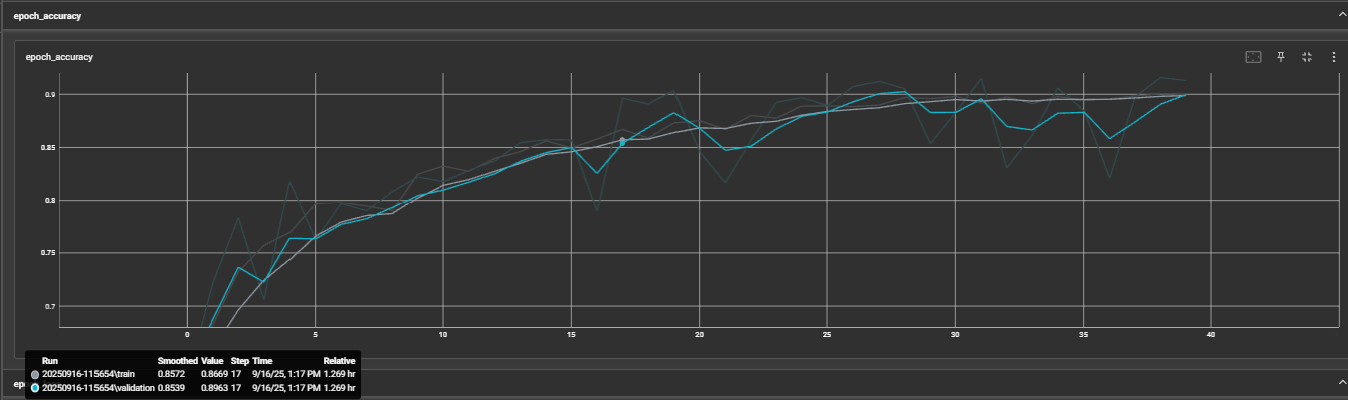

*Epoch-loss*

Este gráfico muestra cómo el error o pérdida (una medida de cuán mal se está desempeñando el modelo) cambia con cada época.

Tendencia General (0 a 40 épocas): La pérdida comienza alta (alrededor de 1.0) y disminuye rápidamente hasta la Época 15, y luego disminuye más lentamente, estabilizándose alrededor de 0.40 - 0.50 después de la Época 30. Esto indica que el modelo está corrigiendo sus errores de manera efectiva.

Estabilidad: Similar al gráfico de precisión, la reducción de la pérdida es mínima después de la Época 30.

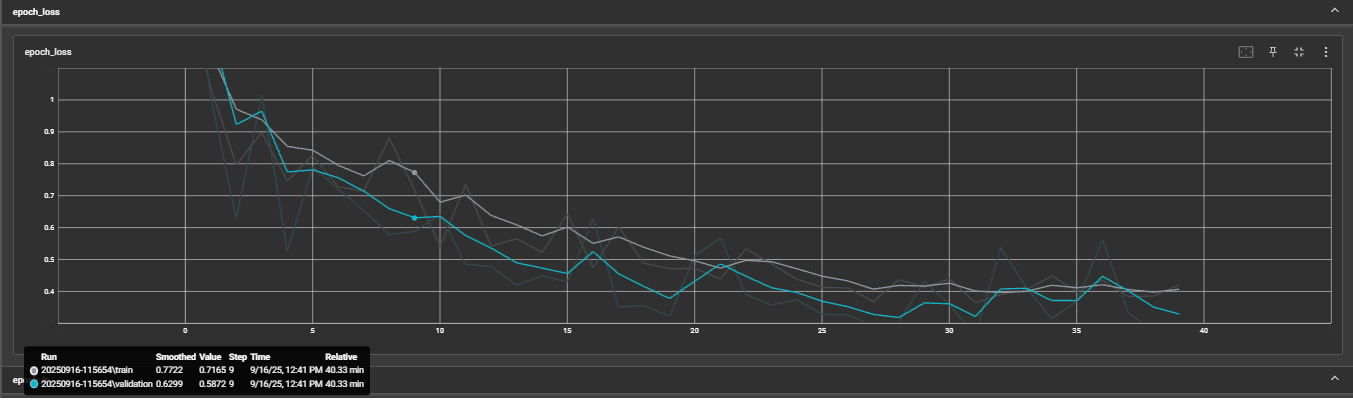

*Epoch-lr*

Este gráfico es fundamental porque revela la estrategia utilizada para ajustar la Tasa de Aprendizaje (LR) del optimizador del modelo durante el entrenamiento. La LR es el tamaño del paso que el modelo da para ajustar los pesos en respuesta al error.

Comportamiento del Gráfico:
Fase de Estabilidad Inicial (Épocas 0 a 8):

La LR se mantiene constante en su valor inicial, aproximadamente 10 
−4
  (o 0.0001). Esto permite al modelo explorar el espacio de pesos con un paso fijo.

Primera Reducción (Épocas 9 a 23):

La LR comienza a disminuir bruscamente (o a caer en pasos discretos, como se ve en la línea gris). Esto es típico de una técnica llamada "Reducción de Tasa de Aprendizaje" (o Learning Rate Schedule).

La LR pasa de 10 
−4
  a aproximadamente 5×10 
−5
  (o 0.00005). Esta reducción se hace cuando la mejora en la métrica de validación (precisión o pérdida, como vimos en el gráfico anterior) se estanca.

Segunda Reducción (Épocas 24 a 35):

Hay otra caída significativa en la LR, que pasa de 5×10 
−5
  a aproximadamente 2.5×10 
−5
 .

El objetivo de reducir la LR es "afinar" el aprendizaje. Con pasos más pequeños, el modelo puede evitar sobrepasar el mínimo global de la función de pérdida y encontrar un punto de convergencia más preciso.

Reducción Final (Épocas 36 a 40):

La LR vuelve a caer, acercándose al rango de 1×10 
−5
  o menos.

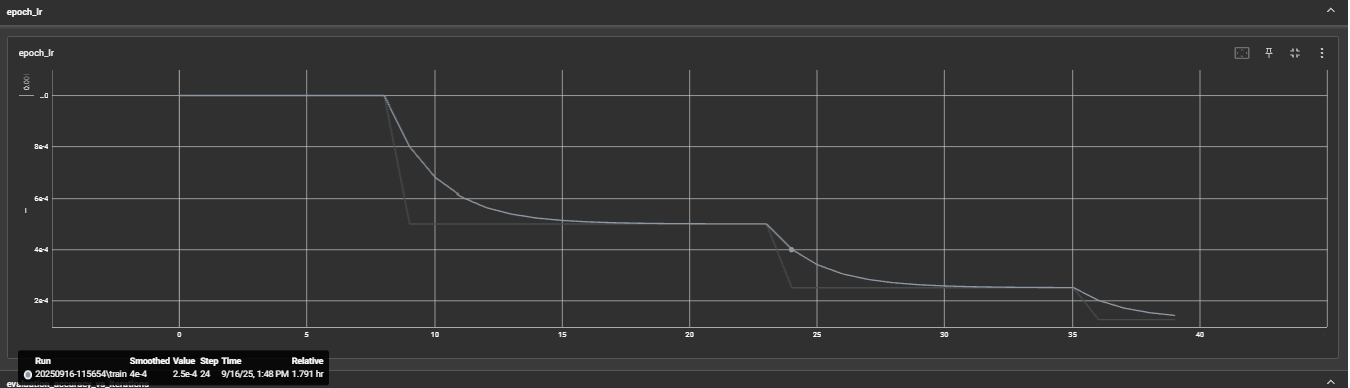

*Matriz de Confusión*

!! La Matriz de Confusión es la herramienta más importante para evaluar la efectividad de un IDS, ya que muestra dónde acierta el modelo (diagonal) y dónde se equivoca (fuera de la diagonal). Los valores están representados en un heatmap (los tonos azules más oscuros indican conteos más altos).

A. Rendimiento del Tráfico Benigno (Fila BENIGN)
Verdaderos Negativos (TN): El modelo predice correctamente BENIGN la inmensa mayoría de las veces (valor más oscuro en la esquina superior izquierda, ≈2,075,000 - mirando el color de la barra).

Falsos Positivos (FP): Sin embargo, el modelo clasifica grandes cantidades de tráfico BENIGN como ataques:

≈9,436 como Brute Force.

≈4,070 como SQL Injection.

≈13,634 como XSS.

≈22,780 como PortScan.

Implicación: Esto indica un riesgo de falsas alarmas (FP). El modelo es demasiado sensible en ciertas áreas, clasificando tráfico normal como ataques de Web Attack (Brute Force, SQL, XSS) o PortScan.

B. Detección de Ataques Comunes (Filas DoS y DDoS)
DDoS (Fila DDoS): El modelo es excelente. Predice correctamente la mayoría como DDoS (≈127,916) y solo clasifica erróneamente unos pocos miles. (Alto Recall).

DoS Hulk (Fila DoS Hulk): El modelo también es muy bueno. Predice correctamente ≈230,787 como DoS Hulk. (Alto Recall).

PortScan (Fila PortScan): El modelo es muy efectivo en detectar PortScan, con ≈158,564 clasificaciones correctas.

C. Dificultades y Falsos Negativos (FN)
Observamos problemas en la detección de clases de ataque menos frecuentes o sutiles (casos de Falsos Negativos donde un ataque se predice como algo más, o peor, como BENIGN):

Bot (Fila Bot):

Mal Clasificado como DDoS: ≈1,961 Bots se clasifican incorrectamente como DDoS.

Mal Clasificado como BENIGN: Solo 5 se clasifican como BENIGN.

SSH-Patator (Fila SSH-Patator): La mayoría se clasifica correctamente (≈5,826), pero ≈72 se clasifican como PortScan y ≈19 como Brute Force.

Ataques Raros (Heartbleed, SQL Injection, XSS):

Heartbleed: Solo 11 se detectan correctamente, y la mayoría de los demás se pierden o se confunden con otras clases, lo que indica un pésimo rendimiento para esta clase.

Web Attack - XSS: Solo 622 se detectan correctamente, pero hay ≈8 clasificados como BENIGN y ≈1 como DDoS.

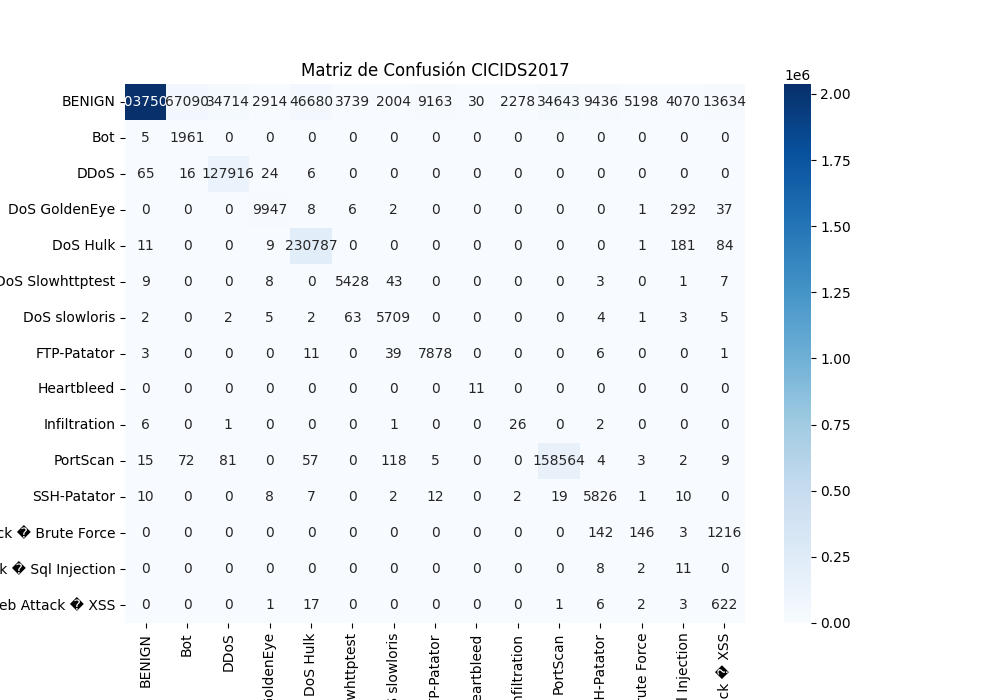

*Distribución de Predicciones del dataset IDS CICIDS2017*

Desbalance de Clases: Hay un extremo desbalance de clases en los datos. La vasta mayoría de las predicciones (>2 millones) corresponden a tráfico BENIGN (Benigno).

Ataques Raros: Las clases de ataque menos frecuentes, como Heartbleed, SQL Injection, o XSS, son predichas en cantidades muy pequeñas, lo cual es de esperar si estos ataques son raros en el conjunto de datos o si el modelo tiene dificultades para detectarlos.

Coherencia: Esta distribución es típica para un dataset de tráfico de red real, donde el tráfico normal (Benigno) supera con creces el tráfico malicioso.

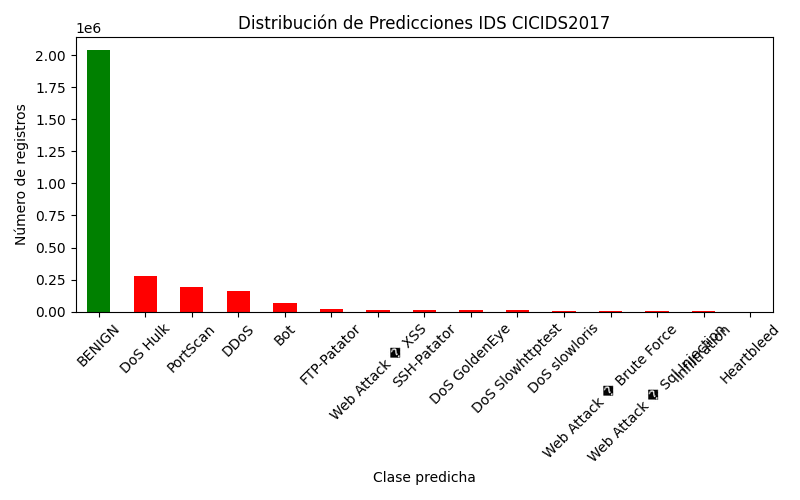

Conclusión

A lo largo de este proyecto he desarrollado un sistema completo de detección de intrusiones basado en aprendizaje profundo, aplicando una red neuronal densa sobre el conjunto de datos CICIDS2017. El trabajo abarcó todas las fases esenciales: desde la recopilación y limpieza de los datos, pasando por la normalización y codificación de las variables, hasta la construcción, entrenamiento y evaluación del modelo. Para abordar la complejidad y el desbalance de las clases presentes en el dataset, integré técnicas como el cálculo de pesos de clase y el uso de estrategias de regularización (BatchNormalization y Dropout), lo que permitió obtener un modelo robusto y capaz de generalizar mejor.

El proceso de entrenamiento se apoyó en mecanismos de parada temprana y ajuste dinámico de la tasa de aprendizaje, garantizando una convergencia estable y evitando el sobreajuste. Los resultados fueron evaluados mediante métricas clásicas de clasificación, la matriz de confusión y la distribución de predicciones, lo que proporcionó una visión clara del comportamiento del modelo en diferentes tipos de tráfico. Además, aseguré la trazabilidad del experimento con el guardado de preprocesadores, artefactos del modelo y registros de entrenamiento.

En conjunto, este trabajo demuestra la viabilidad del uso de técnicas de aprendizaje profundo para la detección de intrusiones en entornos de red. La integración de todo el pipeline —desde el preprocesamiento hasta la inferencia final— constituye una base sólida para un sistema de IDS automatizado, capaz de identificar patrones de tráfico malicioso con un alto grado de precisión y de ofrecer un soporte efectivo en la defensa frente a ciberataques.